<a href="https://colab.research.google.com/github/Sangamithra546/DataScienceLabManual231801147/blob/main/DSexp7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install and import required libraries
!pip install scikit-learn matplotlib pandas numpy

import numpy as np
import pandas as pd
from sklearn.datasets import load_wine
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# For better plots in Colab
%matplotlib inline

In [2]:
# Load wine dataset & preprocess (StandardScaler)
data = load_wine()
X = pd.DataFrame(data.data, columns=data.feature_names)
y_true = data.target   # (not used for clustering, but available if needed)

print("Dataset shape:", X.shape)
print("Feature names:", list(X.columns))

# Standardize the numeric features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Dataset shape: (178, 13)
Feature names: ['alcohol', 'malic_acid', 'ash', 'alcalinity_of_ash', 'magnesium', 'total_phenols', 'flavanoids', 'nonflavanoid_phenols', 'proanthocyanins', 'color_intensity', 'hue', 'od280/od315_of_diluted_wines', 'proline']


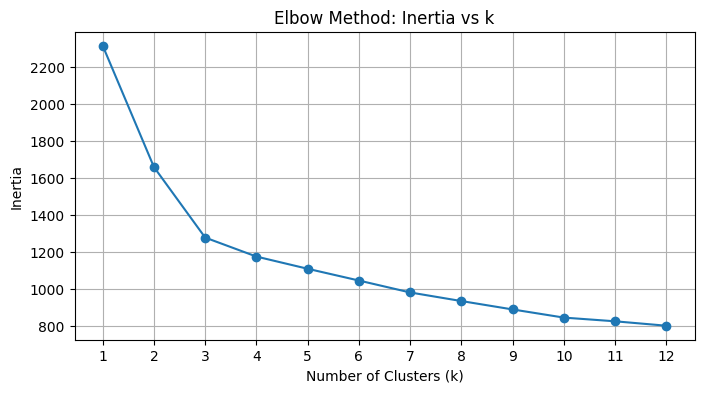

In [3]:
# : Elbow method to find good 'k'
inertias = []
ks = range(1, 13)

for k in ks:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_scaled)
    inertias.append(km.inertia_)

plt.figure(figsize=(8,4))
plt.plot(list(ks), inertias, marker='o')
plt.title('Elbow Method: Inertia vs k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.xticks(list(ks))
plt.grid(True)
plt.show()


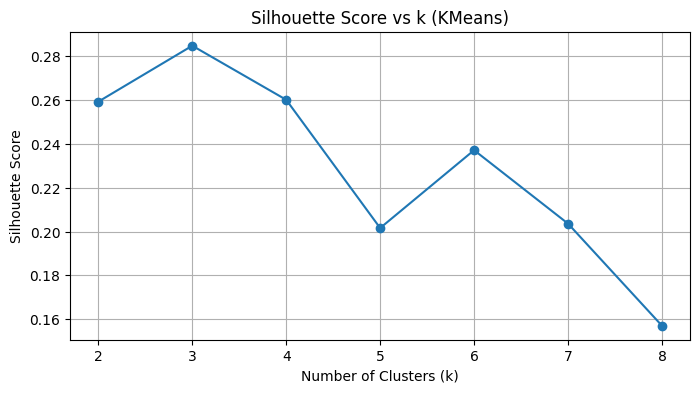

Best k based on silhouette score = 3


In [4]:
# Silhouette scores for k = 2..8
sil_scores = []
ks_eval = range(2, 9)

for k in ks_eval:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_scaled)
    sil = silhouette_score(X_scaled, labels)
    sil_scores.append(sil)

plt.figure(figsize=(8,4))
plt.plot(list(ks_eval), sil_scores, marker='o')
plt.title('Silhouette Score vs k (KMeans)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.xticks(list(ks_eval))
plt.grid(True)
plt.show()

# Pick best k based on silhouette score
best_k = list(ks_eval)[int(np.argmax(sil_scores))]
print(f"Best k based on silhouette score = {best_k}")


KMeans silhouette score (k=3): 0.2849


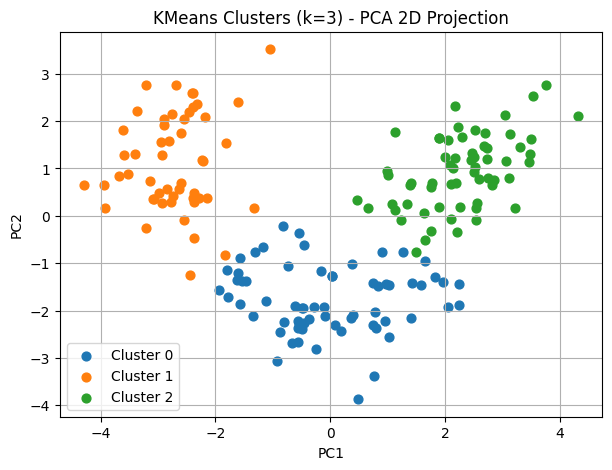

In [5]:
#  Fit KMeans with chosen k and visualize
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=50)
kmeans_labels = kmeans.fit_predict(X_scaled)
kmeans_sil = silhouette_score(X_scaled, kmeans_labels)

print(f"KMeans silhouette score (k={best_k}): {kmeans_sil:.4f}")

# Reduce to 2D for visualization
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(7,5))
for lbl in np.unique(kmeans_labels):
    mask = kmeans_labels == lbl
    plt.scatter(X_pca[mask,0], X_pca[mask,1], label=f'Cluster {lbl}', s=40)
plt.title(f'KMeans Clusters (k={best_k}) - PCA 2D Projection')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.grid(True)
plt.show()


In [6]:
# Generate base clusterings (vary k and random seeds)
base_labelings = []
param_list = []

for k in range(2, 7):           # try different k values
    for seed in [0, 7, 21, 42, 99]:   # multiple random seeds
        km = KMeans(n_clusters=k, random_state=seed, n_init=10)
        labels = km.fit_predict(X_scaled)
        base_labelings.append(labels)
        param_list.append((k, seed))

print(f"Number of base clusterings generated: {len(base_labelings)}")


Number of base clusterings generated: 25


Co-association matrix shape: (178, 178)


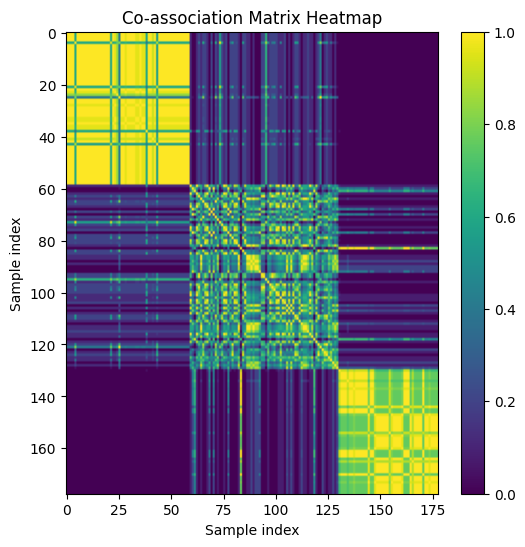

In [7]:
#  Build co-association matrix
n = X_scaled.shape[0]
coassoc = np.zeros((n, n), dtype=float)

for labels in base_labelings:
    eq = (labels.reshape(-1,1) == labels.reshape(1,-1)).astype(float)
    coassoc += eq

coassoc /= len(base_labelings)
print("Co-association matrix shape:", coassoc.shape)

# Optional: visualize heatmap
plt.figure(figsize=(6,6))
plt.imshow(coassoc, aspect='auto')
plt.title('Co-association Matrix Heatmap')
plt.xlabel('Sample index')
plt.ylabel('Sample index')
plt.colorbar()
plt.show()


Ensemble (Spectral on co-assoc) silhouette score: 0.2849


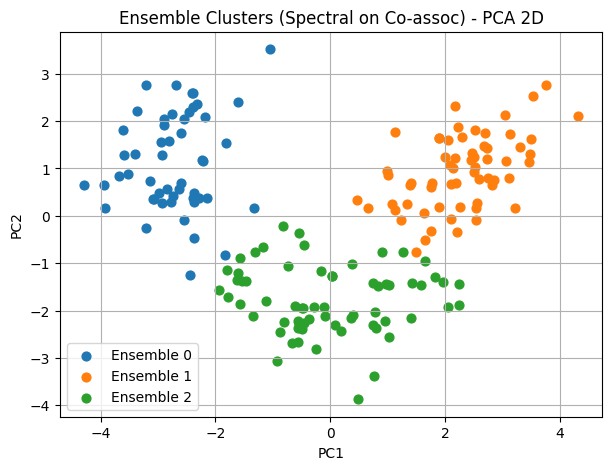

In [8]:
# Spectral clustering (ensemble) on co-association matrix
spec = SpectralClustering(
    n_clusters=best_k,
    affinity='precomputed',
    assign_labels='kmeans',
    random_state=42
)
ensemble_labels = spec.fit_predict(coassoc)

ensemble_sil = silhouette_score(X_scaled, ensemble_labels)
print(f"Ensemble (Spectral on co-assoc) silhouette score: {ensemble_sil:.4f}")

# Visualization on PCA projection
plt.figure(figsize=(7,5))
for lbl in np.unique(ensemble_labels):
    mask = ensemble_labels == lbl
    plt.scatter(X_pca[mask,0], X_pca[mask,1], label=f'Ensemble {lbl}', s=40)
plt.title(f'Ensemble Clusters (Spectral on Co-assoc) - PCA 2D')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.grid(True)
plt.show()


In [9]:
#  Compare KMeans vs Ensemble results
print("Final Comparison:")
print(f"  - KMeans silhouette (k={best_k}): {kmeans_sil:.4f}")
print(f"  - Ensemble silhouette:           {ensemble_sil:.4f}")


Final Comparison:
  - KMeans silhouette (k=3): 0.2849
  - Ensemble silhouette:           0.2849
